# Democracy Reliability
First we need to test if democracy can be reliably measured.

## Python Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
plt.rcParams['figure.dpi'] = 100

## Import data sets


In [3]:
v_dem = pd.read_csv("data/v-dem.csv") # this runs for a while

/Users/micha/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (364,365,366,394,410,821,831,832,930,1233,1250,1479,3071,3290,3291,3346,3348,3352,3353,3355,3356,3357) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
economist = pd.read_csv("data/economist.csv", index_col=[0, 1])

In [5]:
freedom_house = pd.read_excel("data/freedom-house.xlsx", sheet_name="Country Ratings, Statuses ", header=[0, 1, 2], index_col=[0])

## V-Dem Wrangling
Only select most important indicators, create mean of indicators and display.

In [6]:
v_dem_stats = v_dem.loc[:, ["country_name", "historical_date", "v2x_polyarchy", "v2x_libdem", "v2x_partipdem", "v2x_delibdem", "v2x_egaldem"]]
v_dem_stats["historical_date"] = pd.to_datetime(v_dem_stats["historical_date"])
v_dem_stats.set_index(["historical_date"], inplace=True)
v_dem_stats["score"] = v_dem_stats[["v2x_polyarchy", "v2x_libdem", "v2x_partipdem", "v2x_delibdem", "v2x_egaldem"]].mean(axis=1)
v_dem_stats.sort_index(inplace=True)
v_dem_stats: pd.DataFrame = v_dem_stats.groupby("country_name").resample("Y").fillna("pad")
v_dem_stats = v_dem_stats["score"].to_frame()
v_dem_stats = v_dem_stats.groupby([v_dem_stats.index.get_level_values(0), v_dem_stats.index.get_level_values(1).year]).mean()
v_dem_stats.index.set_names(["country_name", "year"], inplace=True)
v_dem_stats.to_hdf("data/democracy.h5", "vdem", mode="a")
v_dem_stats

score
country_name year          
Afghanistan  1789  0.023000
             1790  0.024333
             1791  0.024333
             1792  0.024333
             1793  0.024333
...                     ...
Zimbabwe     2016  0.218600
             2017  0.229000
             2018  0.227600
             2019  0.213200
             2020  0.210000

[28066 rows x 1 columns]

## Economist Data Wrangling

In [7]:
economist_stats = economist.rename({"eiu": "score"}, axis=1)
economist_stats.index.set_names(["country_name", "year"], inplace=True)
economist_stats.sort_index(inplace=True)
economist_stats.to_hdf("data/democracy.h5", "economist", mode="a")
economist_stats

score
country_name year       
Afghanistan  2006   3.06
             2008   3.02
             2010   2.48
             2011   2.48
             2012   2.48
...                  ...
eSwatini     2015   3.09
             2016   3.03
             2017   3.03
             2018   3.03
             2019   3.14

[2004 rows x 1 columns]

## Freedom House Wrangling


In [8]:
freedom_house_stats = freedom_house.droplevel(0, axis=1).rename(columns=lambda name: name.strip() if isinstance(name, str) else name)
freedom_house_stats = freedom_house_stats.stack(level=0)
freedom_house_stats.index.set_names(["country_name", "year"], inplace=True)
freedom_house_stats.rename(index=lambda v: int(v[-4:]) if isinstance(v, str) and (v[-4:]).isnumeric() else v, inplace=True)
freedom_house_stats = freedom_house_stats.apply(pd.to_numeric, errors="coerce")
freedom_house_stats["score"] = freedom_house_stats[["CL", "PR"]].mean(axis=1)
freedom_house_stats.drop("Status", axis=1, inplace=True)
freedom_house_stats.sort_index(inplace=True)
freedom_house_stats = freedom_house_stats["score"].to_frame()
freedom_house_stats.to_hdf("data/democracy.h5", "freedomhouse", mode="a")
freedom_house_stats

score
country_name year       
Afghanistan  1972    4.5
             1973    6.5
             1974    6.5
             1975    6.5
             1976    6.5
...                  ...
Zimbabwe     2016    5.0
             2017    5.5
             2018    5.0
             2019    5.0
             2020    5.5

[9840 rows x 1 columns]

# LinReg
## V-Dem & Economist

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             score-econ   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     8526.
Date:                Mon, 31 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:02:49   Log-Likelihood:                -2456.0
No. Observations:                1836   AIC:                             4916.
Df Residuals:                    1834   BIC:                             4927.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.0502      0.044     46.778      0.000       1.964       2.136
score-v-dem     8.1655      0.088     92.334      0.000       7.992       8.339
==============================================================================
Omnibus:                        8.157   Durbin-Watson:                   0.273
Prob(Omnibus):                  0.017   Jarque-Bera (JB):                9.331
Skew:                           0.089   Prob(JB):                      0.00942
Kurtosis:                       3.301   Cond. No.                         4.91
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

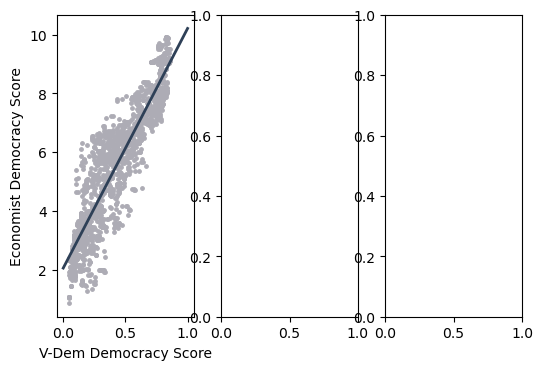

In [9]:
v_dem_economist = v_dem_stats.join(economist_stats, lsuffix="-v-dem", rsuffix="-econ").dropna()
X = sm.add_constant(v_dem_economist["score-v-dem"])
Y = v_dem_economist["score-econ"]
model_v_ec = sm.OLS(Y, X)
res_v_ec = model_v_ec.fit()

fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
ax0.scatter(v_dem_economist["score-v-dem"], Y, 6, marker="o", color="#ADACB5")
x = np.linspace(0, 1)
ax0.plot(x, res_v_ec.params[0] + res_v_ec.params[1] * x, linewidth=2, color="#2E4057")
ax0.set(xlabel="V-Dem Democracy Score", ylabel="Economist Democracy Score")
fig.set(edgecolor="#ADACB5")
res_v_ec.summary()

## V-Dem & Freedom House

In [10]:
v_dem_freedom = v_dem_stats.join(freedom_house_stats, lsuffix="-v-dem", rsuffix="-fhouse").dropna()
X = sm.add_constant(v_dem_freedom["score-v-dem"])
Y = v_dem_freedom["score-fhouse"]
model_v_fr = sm.OLS(Y, X)
res_v_fr = model_v_fr.fit()
ax1.scatter(v_dem_freedom["score-v-dem"], Y, 4)
x = np.linspace(0, 0.8)
ax1.plot(x, res_v_fr.params[0] + res_v_fr.params[1] * x, linewidth=2)
ax1.set(xlabel="V-Dem Score", ylabel="Freedom House Score")
res_v_fr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           score-fhouse   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                 3.847e+04
Date:                Mon, 31 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:02:49   Log-Likelihood:                -8869.1
No. Observations:                7381   AIC:                         1.774e+04
Df Residuals:                    7379   BIC:                         1.776e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.4614      0.016    395.632      0.000       6.429       6.493
score-v-dem    -7.1548      0.036   -196.149      0.000      -7.226      -7.083
==============================================================================
Omnibus:                      414.031   Durbin-Watson:                   0.258
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              516.079
Skew:                          -0.559   Prob(JB):                    8.61e-113
Kurtosis:                       3.656   Cond. No.                         4.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Freedom House & Economist

In [11]:
economist_freedom = economist_stats.join(freedom_house_stats, lsuffix="-econ", rsuffix="-fhouse").dropna()
X = sm.add_constant(economist_freedom["score-econ"])
Y = economist_freedom["score-fhouse"]
model_ec_fr = sm.OLS(Y, X)
res_ec_fr = model_ec_fr.fit()
ax2.scatter(economist_freedom["score-econ"], Y, 4)
x = np.linspace(0, 10)
ax2.plot(x, res_ec_fr.params[0] + res_ec_fr.params[1] * x, linewidth=2)
ax2.set(xlabel="Economist Democracy Score", ylabel="Freedom House Democracy Score")
res_ec_fr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           score-fhouse   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                 1.321e+04
Date:                Mon, 31 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:02:49   Log-Likelihood:                -1963.6
No. Observations:                1872   AIC:                             3931.
Df Residuals:                    1870   BIC:                             3942.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.1320      0.043    188.280      0.000       8.047       8.217
score-econ    -0.8328      0.007   -114.943      0.000      -0.847      -0.819
==============================================================================
Omnibus:                        5.215   Durbin-Watson:                   0.341
Prob(Omnibus):                  0.074   Jarque-Bera (JB):                5.219
Skew:                          -0.104   Prob(JB):                       0.0736
Kurtosis:                       3.155   Cond. No.                         16.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

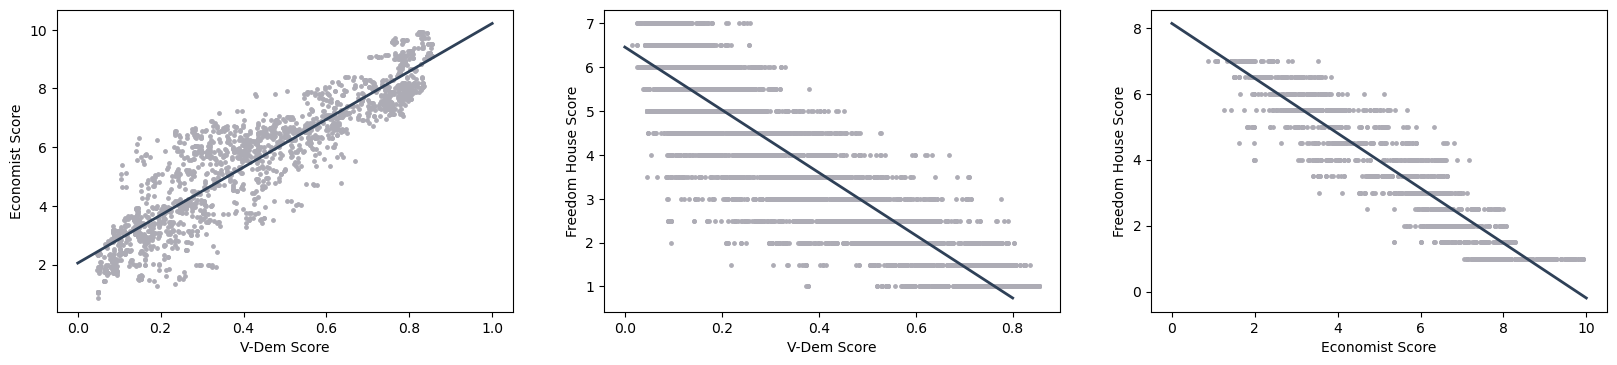

In [32]:
v_dem_economist = v_dem_stats.join(economist_stats, lsuffix="-v-dem", rsuffix="-econ").dropna()
X = sm.add_constant(v_dem_economist["score-v-dem"])
Y = v_dem_economist["score-econ"]
model_v_ec = sm.OLS(Y, X)
res_v_ec = model_v_ec.fit()

fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
ax0.scatter(v_dem_economist["score-v-dem"], Y, 6, marker="o", color="#ADACB5")
x = np.linspace(0, 1)
ax0.plot(x, res_v_ec.params[0] + res_v_ec.params[1] * x, linewidth=2, color="#2E4057")
ax0.set(xlabel="V-Dem Score", ylabel="Economist Score")
res_v_ec.summary()

v_dem_freedom = v_dem_stats.join(freedom_house_stats, lsuffix="-v-dem", rsuffix="-fhouse").dropna()
X = sm.add_constant(v_dem_freedom["score-v-dem"])
Y = v_dem_freedom["score-fhouse"]
model_v_fr = sm.OLS(Y, X)
res_v_fr = model_v_fr.fit()
ax1.scatter(v_dem_freedom["score-v-dem"], Y, 6, marker="o", color="#ADACB5")
x = np.linspace(0, 0.8)
ax1.plot(x, res_v_fr.params[0] + res_v_fr.params[1] * x, linewidth=2, color="#2E4057")
ax1.set(xlabel="V-Dem Score", ylabel="Freedom House Score")
res_v_fr.summary()

economist_freedom = economist_stats.join(freedom_house_stats, lsuffix="-econ", rsuffix="-fhouse").dropna()
X = sm.add_constant(economist_freedom["score-econ"])
Y = economist_freedom["score-fhouse"]
model_ec_fr = sm.OLS(Y, X)
res_ec_fr = model_ec_fr.fit()
ax2.scatter(economist_freedom["score-econ"], Y, 6, marker="o", color="#ADACB5")
x = np.linspace(0, 10)
ax2.plot(x, res_ec_fr.params[0] + res_ec_fr.params[1] * x, linewidth=2, color="#2E4057")
ax2.set(xlabel="Economist Score", ylabel="Freedom House Score")
res_ec_fr.summary()

fig.set_figwidth(20)
# fig.suptitle("Democracy score comparison", fontsize=24, weight=500, y=1.0)